In [7]:
# Run if you are on Google Colab to install the Python bindings
!bash compile.sh

running build_ext
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include/python3.6m -c flagcheck.cpp -o flagcheck.o -std=c++17
building 'monotone' extension
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -DVERSION_INFO=0.0.1 -I/Users/wonjunlee/miniconda3/envs/cv/lib/python3.6/site-packages/pybind11/include -I/Users/wonjunlee/miniconda3/envs/cv/include/python3.6m -c src/main.cpp -o build/temp.macosx-10.9-x86_64-3.6/src/main.o -std=c++17 -mmacosx-version-min=10.14 -fvisibility=hidden -g0 -stdlib=libc++ -std=c++17
g++ -bundle -undefined dynamic_lookup -L/Users/wonjunlee/miniconda3/envs/cv/lib -arch x86

In [8]:
import argparse
import os
import numpy as np
import math
import sys
import copy
import time
import matplotlib.pyplot as plt
from monotone import Affine3DSolver

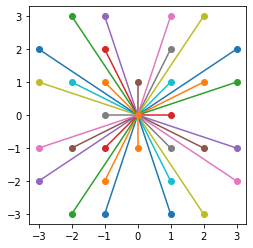

In [9]:
# 2D version

# Let's get a numpy array that contains the list of stencils given the stencil size in 3D
stencil_size = 3
stencils_tmp = []
# add cases for i0 == 0

for i1 in range(-stencil_size, stencil_size+1):
    for i2 in range(-stencil_size, stencil_size+1):
        if i1!= 0 or i2!=0:
            stencils_tmp.append((0,i1,i2, np.arctan2(i1,i2), i1*i1 + i2*i2))

stencils_tmp.sort(key=lambda x: x[4])
stencils_tmp.sort(key=lambda x: x[3])
stencils = []
for i, it in enumerate(stencils_tmp):
    if i == 0:
        stencils.append(it[:3])
    else:
        if it[3] != stencils_tmp[i-1][3]:
            stencils.append(it[:3])

fig = plt.figure()
ax = fig.add_subplot(111)
for i in stencils:
    ax.plot([0,i[1]], [0,i[2]], 'o-')
ax.set_aspect('equal')
plt.show()

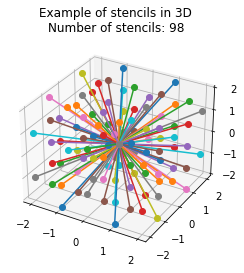

In [10]:
# 3D version

# Given a stencil_size, this function will return a numpy array of size [ __, 3 ]
# If stencil_size = 1 then it provides stencils ranging from -1 to 1
# If stencil_size = 2 then it provides stencils ranging from -2 to 2
def create_stencils_3d(stencil_size):
    stencils_tmp = []
    # add cases for i0 == 0
    for i0 in range(-stencil_size, stencil_size+1):
        for i1 in range(-stencil_size, stencil_size+1):
            for i2 in range(-stencil_size, stencil_size+1):
                if i0!=0 or i1!=0 or i2!=0:
                    stencils_tmp.append((i0,i1,i2, np.arctan2(i0,i1), np.arctan2(i0,i2), np.arctan2(i1,i2), i0*i0 + i1*i1 + i2*i2))

    stencils_tmp.sort(key=lambda x: x[6])
    stencils_tmp.sort(key=lambda x: x[5])
    stencils_tmp.sort(key=lambda x: x[4])
    stencils_tmp.sort(key=lambda x: x[3])

    stencils = []
    for i, it in enumerate(stencils_tmp):
        if i == 0:
            stencils.append(it[:3])
        else:
            if it[3] != stencils_tmp[i-1][3] or it[4] != stencils_tmp[i-1][4] or it[5] != stencils_tmp[i-1][5]:
                stencils.append(it[:3])

    del stencils_tmp
    return np.array(stencils)

# Let's get a numpy array that contains the list of stencils given the stencil size in 3D
stencil_size = 2
stencils = create_stencils_3d(stencil_size)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in stencils:
    ax.plot([0,i[0]], [0,i[1]], [0,i[2]], 'o-')
ax.set_title(f"Example of stencils in 3D\nNumber of stencils: {len(stencils)}")
plt.show()

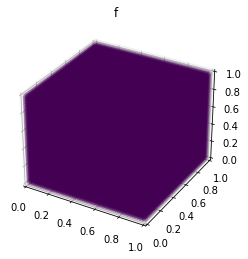

In [11]:
# create an empty f
n = 50
f = np.zeros((n,n,n))
u = np.zeros((n,n,n))

# initializing f
xx = np.linspace(0.5/n,1-0.5/n,n)
X,Y,Z = np.meshgrid(xx,xx,xx)
X2,Y2 = np.meshgrid(xx,xx)

def f_ellipse():
    f = np.zeros((n,n,n))
    theta = -np.pi/3.0
    Xr = 0.5 + np.cos(theta)*(X-0.5) - np.sin(theta)*(Y-0.5)
    Yr = 0.5 + np.sin(theta)*(X-0.5) + np.cos(theta)*(Y-0.5)
    f[4*pow(Xr - 0.5,2) + pow(Yr-0.5,2) + pow(Z-0.5,2) < 0.5 ** 2] = 1
    return f

# f = f_ellipse()
f[(np.abs(X-0.5)<0.5) & (np.abs(Y-0.5)<0.5) & (np.abs(Z-0.5)<0.5)] = 1
# f[(np.abs(X-0.5)<0.3) & (np.abs(Y-0.5)<0.3) & (np.abs(Z-0.5)<0.3)] = 1
# f[((X-0.3)**2 + (Y-0.3)**2 + (Z-0.3)**2 <0.3**2) | ((X-0.7)**2 + (Y-0.7)**2 + (Z-0.7)**2 <0.3**2)] = 1


# returning contiguous arrays in memory
u = np.ascontiguousarray(u, dtype=np.float64)  # solution
f = np.ascontiguousarray(f, dtype=np.float64)  # the right hand side function

# plotting f
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
mask = f > 0
ax.scatter3D(X[mask],Y[mask],Z[mask], c = f[mask], alpha=0.2)
ax.set_xlim3d([0,1])
ax.set_ylim3d([0,1])
ax.set_zlim3d([0,1])
ax.set_title("f")
plt.show()

In [ ]:
# make folder if not exists
save_fig_path = 'figures'
if not os.path.exists(save_fig_path):
    os.makedirs(save_fig_path)
save_data_path = 'data'
if not os.path.exists(save_data_path):
    os.makedirs(save_data_path)

# optimization parameters
max_iter = 1000
tolerance= 1e-3

# initialize the HJ solver
solver = Affine3DSolver(f, stencils, stencil_size)

# Running the iterations
start_time = time.time()
error_array = []
offset_arr = [5, 15,25, 35, 45]
for i in range(max_iter):
    error = solver.perform_one_iteration(u)
    error_array.append(error)
    # print(f"i: {i} error: {error:0.2e} time: {time.time() - start_time:0.2e} sec")
    # if error is less than tolerance stop the iteration
    if error < tolerance:
        break
    # save figures
    if i % 10 == 0:
        fig = plt.figure(figsize=(15,5))
        
        for ii in range(5):
            ax = fig.add_subplot(2,5,ii+1)
            ax.contourf(X2,Y2,u[offset_arr[ii],:,:])
            ax.axis('off')
            ax.set_aspect('equal')
        title_str = f"i: {i} error: {error:0.2e} time: {time.time() - start_time:0.2e} sec"
        plt.title(title_str)
        ax = fig.add_subplot(2,1,2)
        ax.plot(error_array,'o-')
        plt.savefig(f"{save_fig_path}/fig-{i//10}.png")
        plt.show()
    # save data
    if i % 100 == 0:
        np.save(f"{save_data_path}/data-{i//100}.npy",u)
    

Constructor finished. n:  50 stencil size:  2 number of stencils:  98


KeyboardInterrupt: 

In [ ]:
# plotting the result
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection="3d")
skip = 4
mask = f[::skip,::skip,::skip] > 0
ax.scatter3D(X[::skip,::skip,::skip][mask],Y[::skip,::skip,::skip][mask],Z[::skip,::skip,::skip][mask], c = u[::skip,::skip,::skip][mask], alpha=0.8)
ax.set_xlim3d([0,1])
ax.set_ylim3d([0,1])
ax.set_zlim3d([0,1])
plt.tight_layout()
plt.savefig(f"{save_fig_path}/3d-particle.png")
# ax.set_title("f")
plt.show()

In [ ]:
# plotting the result
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection="3d")
plot_N = 4
offset_arr = [5, 15, 25, 35, 45]

for ii in offset_arr:
    ax.contourf(X2,Y2,u[ii,:,:],offset=ii/n, alpha=0.7)
ax.set_xlim3d([0,1])
ax.set_ylim3d([0,1])
ax.set_zlim3d([0,1])
ax.view_init(10,10)
# ax.set_title("Computed solution")
plt.tight_layout(0)
plt.savefig(f"{save_fig_path}/3d-plot.png")
plt.show()

In [ ]:
pow(3,2)